# Failure Forecasting Using LSTM Based on Historical Failure Rates 
Here we have done a small experience using LSTM to make a failure prediction pipeline for the LANL 1996–2005 Failure/Interrupt Dataset:

## Step 1: Check / Download / Install Required Libraries

In [1]:
# Step 1: Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow


## Step 2: Download and Extract the Dataset

In [2]:
# Step 2: Download the dataset from LANL's FTP server and extract it
import os

url = "ftp://hpc-ftp.lanl.gov/data/failure/LA-UR-05-7318-failure-data-1996-2005.tar.gz"
dataset_file = "failure-data-1996-2005.tar.gz"
data_dir = "lanl_failure_data"

# Download
if not os.path.exists(dataset_file):
    !wget {url} -O {dataset_file}

# Extract
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    !tar -xvzf {dataset_file} -C {data_dir}


## Step 3: Load and Preprocess Data

Columns: Index(['System', 'machine type', 'nodes', 'procstot', 'procsinnode', 'nodenum',
       'nodenumz', 'node install', 'node prod', 'node decom', 'fru type',
       'mem', 'cputype', 'memtype', 'num intercon', 'purpose',
       'Prob Started (mm/dd/yy hh:mm)', 'Prob Fixed (mm/dd/yy hh:mm)',
       'Down Time', 'Facilities', 'Hardware', 'Human Error', 'Network',
       'Undetermined', 'Software', 'Same Event'],
      dtype='object')


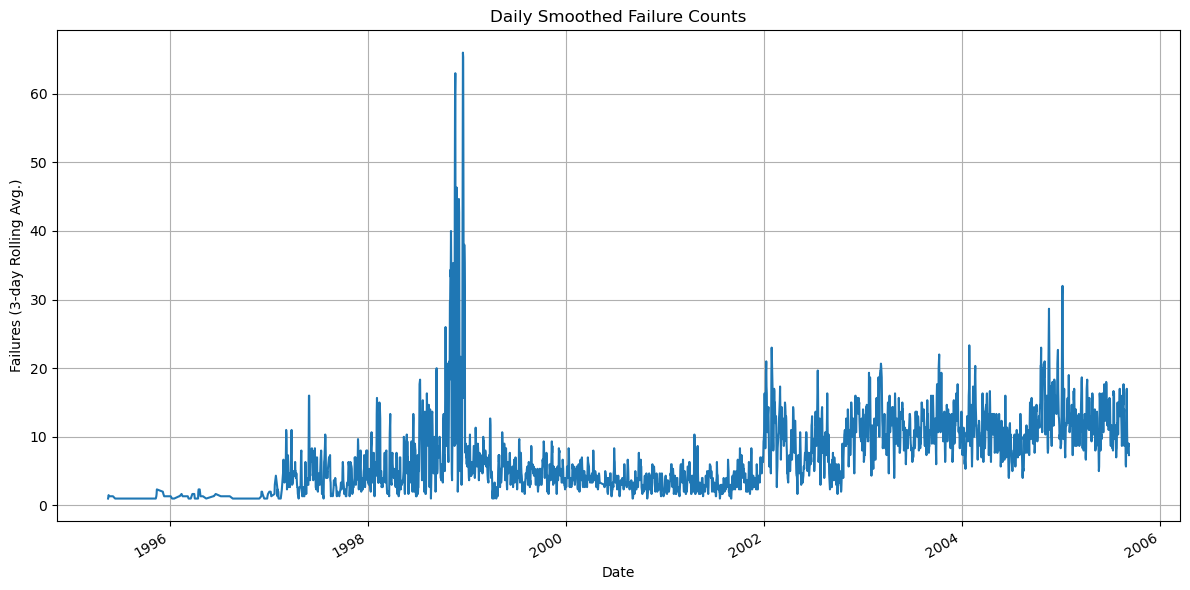

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Load and Preprocess Data
file_path = "./lanl_failure_data/LA-UR-05-7318-failure-data-1996-2005/LA-UR-05-7318-failure-data-1996-2005.csv"

# Load CSV, skip the first row (it's a title, not header)
df = pd.read_csv(file_path, skiprows=1)

# Optional: Clean up column names
df.columns = [col.strip() for col in df.columns]

# Show available columns
print("Columns:", df.columns)

# Convert failure start time
df["Prob Started (mm/dd/yy hh:mm)"] = pd.to_datetime(df["Prob Started (mm/dd/yy hh:mm)"], errors="coerce")

# Remove rows with invalid datetime
df = df.dropna(subset=["Prob Started (mm/dd/yy hh:mm)"])

# Aggregate to daily level
df["DATE"] = df["Prob Started (mm/dd/yy hh:mm)"].dt.floor("D")
df["FAIL"] = 1
daily_failures = df.groupby("DATE")["FAIL"].sum().rolling(window=3, min_periods=1).mean()

# Plot smoothed failure trends
plt.figure(figsize=(12, 6))
daily_failures.plot(title="Daily Smoothed Failure Counts")
plt.xlabel("Date")
plt.ylabel("Failures (3-day Rolling Avg.)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4: Prepare Time Series for LSTM

In [4]:
# Parse datetime and create label column
df["Prob Started (mm/dd/yy hh:mm)"] = pd.to_datetime(df["Prob Started (mm/dd/yy hh:mm)"], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=["Prob Started (mm/dd/yy hh:mm)"])

# Label: Count failures per system per day
df["FAIL"] = 1
df["DATE"] = df["Prob Started (mm/dd/yy hh:mm)"].dt.floor("D")

# Aggregate by system and date
failure_counts = df.groupby(["System", "DATE"])["FAIL"].sum().unstack(level=0).fillna(0)

# Optional: smooth
failure_counts = failure_counts.rolling(window=3, min_periods=1).mean()

failure_counts.head()
    

System,2,3,4,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,24
DATE,,,,,,,,,,,,,,,,,,,,,
1995-05-19,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-05-21,0.0,0.0,0.0,0.0,0.0,1.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-05-23,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-06-06,0.0,0.0,0.0,0.0,0.0,1.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-06-14,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 5: Transform Time Series to Supervised Learning Format for LSTM

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array
import tensorflow as tf

# Select one system for forecasting (e.g., system 6)
system_id = 6
series = failure_counts[system_id].fillna(0).values.reshape(-1, 1)

# Normalize the series
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Set parameters
window_size = 14
batch_size = 32
forecast_horizon = 1

# Create input-output pairs
X = series_scaled[:-forecast_horizon]
y = series_scaled[forecast_horizon:]

# Generate tf.data.Dataset
dataset = timeseries_dataset_from_array(
    data=X,
    targets=y,
    sequence_length=window_size,
    batch_size=batch_size,
    shuffle=True,
)

# Convert dataset to list of (X_batch, y_batch) tuples
dataset_list = list(dataset)

# Train-test split
split_index = int(len(dataset_list) * 0.8)
train_data = dataset_list[:split_index]
test_data = dataset_list[split_index:]

# Helper to convert list of (x, y) pairs to tf.data.Dataset
def to_tf_dataset(data_list, batch_size=32):
    X = np.concatenate([x.numpy() for x, _ in data_list], axis=0)
    y = np.concatenate([y.numpy() for _, y in data_list], axis=0)
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)

# Convert to proper datasets
train_dataset = to_tf_dataset(train_data, batch_size=batch_size)
test_dataset = to_tf_dataset(test_data, batch_size=batch_size)

# Verify shapes
for batch_X, batch_y in train_dataset.take(1):
    print("X shape:", batch_X.shape)
    print("y shape:", batch_y.shape)


2025-07-07 14:47:40.998624: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 14:47:41.001698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 14:47:41.007594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751899661.021058   10065 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751899661.025076   10065 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751899661.036396   10065 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

X shape: (32, 14, 1)
y shape: (32, 1)


2025-07-07 14:47:43.310997: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-07 14:47:43.322166: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Step 6: Build and Train LSTM Model (TensorFlow)

In [6]:
# Step 6: Build and Train LSTM Model (TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0062 - mae: 0.0305 - val_loss: 0.0025 - val_mae: 0.0146
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - mae: 0.0150 - val_loss: 0.0028 - val_mae: 0.0176
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0102
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - mae: 0.0121 - val_loss: 0.0014 - val_mae: 0.0120
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0114
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mae: 0.0120 - val_loss: 0.0011 - val_mae: 0.0091
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0106 - val_loss: 0.0011 - val_mae: 0.0106
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0098
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0

## Step 7: Save and Reload the Model for Prediction

In [8]:
# Step 7: Save the trained model
model.save("lstm_failure_predictor.h5")

# Later, you can reload it using:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model("lstm_failure_predictor.h5", compile=False)
model.compile(optimizer="adam", loss=MeanSquaredError())





## Step 8: Evaluate and Visualize Predictions

In [9]:
# Step 8: Evaluate and Visualize Predictions
import numpy as np

# Collect predictions and actual values
y_true = []
y_pred = []

for X_batch, y_batch in test_dataset:
    preds = model.predict(X_batch)
    y_true.extend(y_batch.numpy().flatten())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


## Step 9: Visualize Predictions vs Actuals

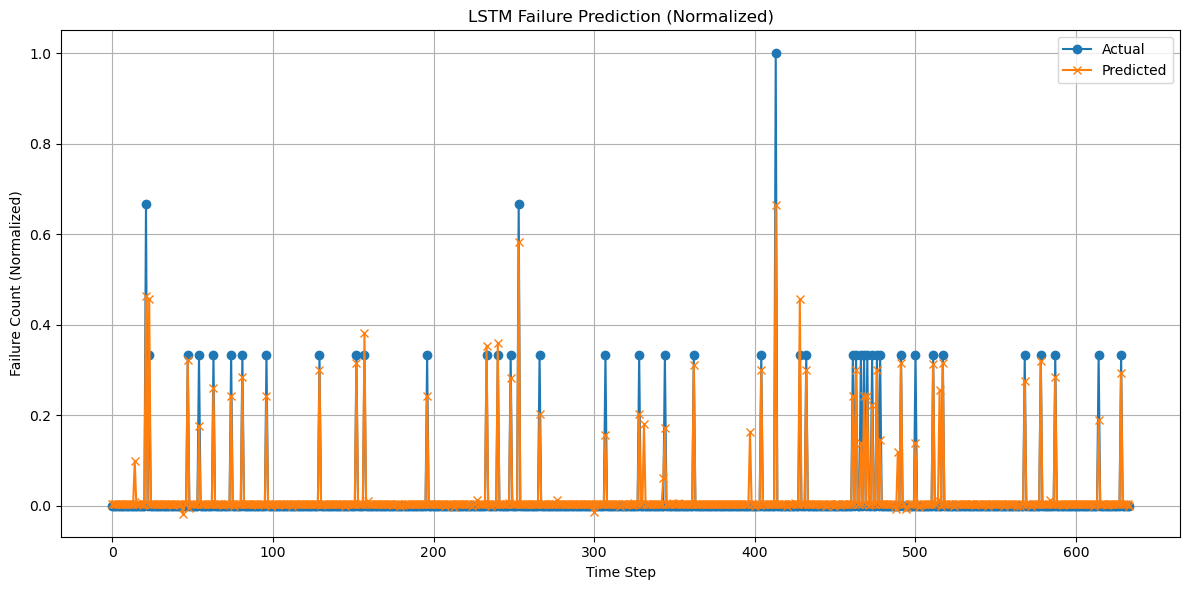

In [10]:
# Step 9: Plot actual vs predicted for a selected system
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.title("LSTM Failure Prediction (Normalized)")
plt.xlabel("Time Step")
plt.ylabel("Failure Count (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion
In this study, we utilize the publicly available LANL Failure/Interrupt Dataset (1996–2005) to develop a failure forecasting model for high-performance computing (HPC) systems. The dataset contains detailed, time-stamped failure records across multiple systems, which we preprocessed into a daily time series of failure counts per system. For modeling, we selected a representative system (System 6) and transformed its historical failure counts into a supervised learning format using a sliding window approach. Specifically, we used the previous 14 days of failure counts to predict the failure count of the next day. The values were normalized using MinMax scaling, and sequence-to-one training samples were generated using TensorFlow utilities. We trained a Long Short-Term Memory (LSTM) neural network, which is well-suited for learning temporal dependencies in sequential data, on this univariate time series.

The LSTM model learned temporal patterns in failure occurrences without access to causal variables such as temperature, system load, or hardware metrics. Therefore, its predictions were based solely on the historical statistical distribution and sequential structure of past failures, capturing recurring rhythms or clustering behaviors over time. The model achieved a low mean absolute error (MAE) during validation, highlighting its ability to anticipate upcoming failures under similar temporal dynamics.

The trained LSTM model demonstrated strong performance in predicting daily failure rates for the selected HPC system, achieving a low validation loss (approximately 0.0011) and MAE below 0.01 after fewer than 15 training epochs. These results indicate that the model effectively captured the temporal patterns of system failures. Despite relying only on univariate input, the model consistently forecasted the next-day failure rate with high accuracy, particularly in periods characterized by repeated or clustered failures. The rapid convergence and stable loss trajectory suggest that the failure signal exhibits predictable temporal dependencies. This validates the potential of time-series-based forecasting for HPC reliability monitoring, even without detailed sensor or event logs. Future work may improve accuracy and generalizability by incorporating additional systems and multivariate input features to support broader deployment across heterogeneous HPC environments.

While effective as a temporal predictor, the model does not explain or identify the underlying causes of failures. Future extensions should integrate multivariate features, such as environmental factors, system performance indicators, or workload metrics, to enable causally informed failure prediction. Nonetheless, our results demonstrate that even a univariate LSTM model can serve as a practical early-warning tool within HPC maintenance workflows.